# Install Dependencies

## External Dependencies

In [1]:
!pip install seaborn matplotlib


[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: pip install --upgrade pip


## FrostAura Dependencies

In [2]:
import os
import sys

USE_LOCAL_CODE: bool = True # NOTE: When changing this configuration, be sure to restart the interpreter in order to have sys path updates reflect.
directories_to_move_up: int = 2
current_executing_path: str = os.getcwd()
current_executing_path = current_executing_path.replace('\\', '/')
root_path: str = '/'.join(current_executing_path.split('/')[:-directories_to_move_up])

# Clean up.
%pip uninstall frostaura -y
sys.path = [p for p in sys.path if p != root_path]

if USE_LOCAL_CODE:
    sys.path.append(root_path)
else:
    %pip install -U --no-cache-dir frostaura

Note: you may need to restart the kernel to use updated packages.


# Import Dependencies

## Logging

In [3]:
import logging

logging.getLogger().disabled = True

## Imports

In [4]:
from frostaura.engines import IAssetProjectionEngine
from frostaura.engines import SimpleAssetProjectionEngine
import pandas as pd
from frostaura.engines import IAssetValuationEngine
from frostaura.engines import FinvizAssetValuationEngine
from frostaura.engines import IAssetCalculationsEngine
from frostaura.engines import SimpleAssetCalculationsEngine
from frostaura.data_access import EasyEquitiesPersonalAssetDataAccess
from frostaura.data_access import IResourcesDataAccess
from frostaura.data_access import EmbeddedResourcesDataAccess
from frostaura.data_access import HtmlResourcesDataAccess
from frostaura.data_access import IPersonalAssetDataAccess
from frostaura.data_access import IPublicAssetDataAccess
from frostaura.data_access import YahooFinanceDataAccess
from frostaura.engines import IVisualizationEngine
from frostaura.engines import FrostAuraVisualizationEngine
from frostaura.models.visualization_types import VisualizationType

# Usage

## Setup

In [5]:
html_data_access: IResourcesDataAccess = HtmlResourcesDataAccess()
resource_data_access: IResourcesDataAccess = EmbeddedResourcesDataAccess()
asset_valuation_engine: IAssetValuationEngine = FinvizAssetValuationEngine(html_data_access=html_data_access)
public_asset_data_access: IPublicAssetDataAccess = YahooFinanceDataAccess()
asset_calculations_engine: IAssetCalculationsEngine = SimpleAssetCalculationsEngine(public_asset_data_access=public_asset_data_access)
personal_asset_data_access: IPersonalAssetDataAccess = EasyEquitiesPersonalAssetDataAccess(resource_data_access=resource_data_access,
                                                                         username=None,
                                                                         password=None)
asset_projection_engine: IAssetProjectionEngine = SimpleAssetProjectionEngine(asset_valuation_engine=asset_valuation_engine,
                                                               public_asset_data_access=public_asset_data_access)
instance: IVisualizationEngine = FrostAuraVisualizationEngine()

## Project for a Single Symbol

In [6]:
n_months: int = 12*30 # 39 year
usd_zar_exchange_rate: float = 16.17
symbol: str = 'AAPL'
holdings: pd.DataFrame = personal_asset_data_access.get_personal_transactions()
holdings_with_profits: pd.DataFrame = asset_calculations_engine.calculate_holdings_profits(holdings=holdings)
initial_value: float = holdings_with_profits.loc[holdings_with_profits['symbol'] == 'AAPL']['total_current_usd'].sum()
monthly_deposit: float = 2000 / usd_zar_exchange_rate / len(holdings_with_profits)

growth: pd.DataFrame = asset_projection_engine.project_monthly_asset_growth(n_months=n_months,
                                                             symbol=symbol,
                                                             principal_value=initial_value,
                                                             monthly_deposit=monthly_deposit).reset_index()

growth

,month,deposits_withdrawals,interest,total_deposits_withdrawals,accrued_interest,balance
0,0,0.000000,0.000000,0.000000,0.000000,75.007486
1,1,30.921459,0.614436,30.921459,0.614436,106.543382
2,2,30.921459,0.872768,61.842919,1.487204,138.337610
3,3,30.921459,1.153582,92.764378,2.640786,170.412651
4,4,30.921459,1.395964,123.685838,4.036750,202.730074
...,...,...,...,...,...,...
356,356,30.921459,546.783035,11008.039579,56243.349366,67326.396432
357,357,30.921459,561.427339,11038.961039,56804.776705,67918.745230
358,358,30.921459,556.367721,11069.882498,57361.144426,68506.034411
359,359,30.921459,561.178599,11100.803958,57922.323025,69098.134469


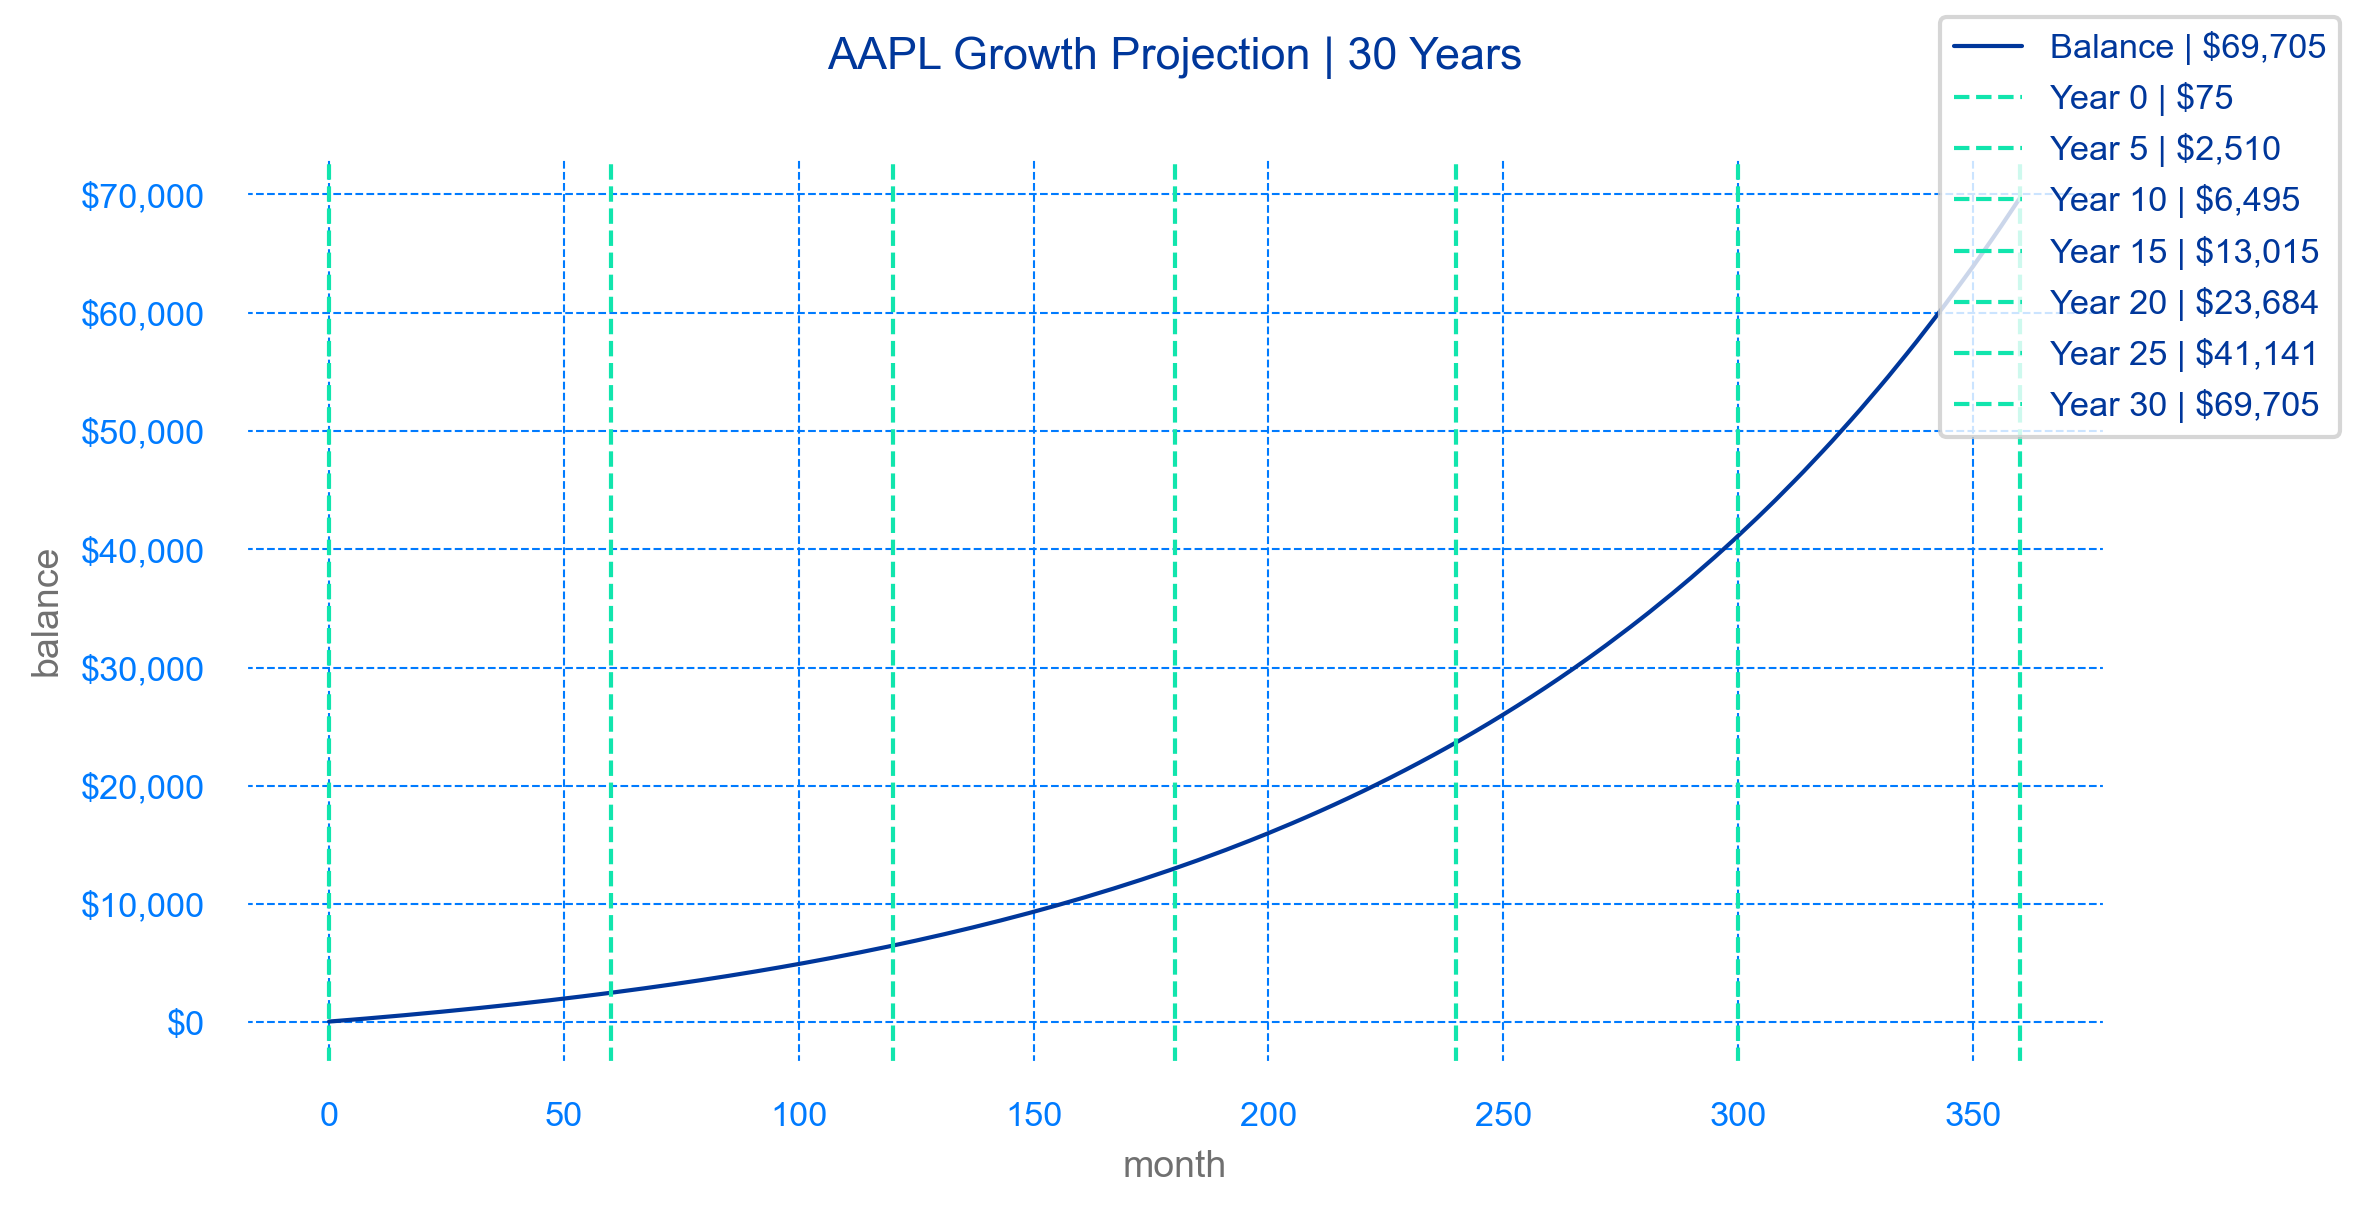

In [7]:
currency_format: str = '${x:,.0f}'
fig, ax = instance.get_figure(x='month',
                              y='balance',
                              data=growth,
                              graph_type=VisualizationType.LINE,
                              title=f'{symbol} Growth Projection | 30 Years',
                              legend=True,
                              line_label=f'Balance | {currency_format.format(x=growth.iloc[-1]["balance"])}',
                              y_tick_format_str=currency_format)

for i, r in growth.iterrows():
    # Draw a line for every 5 year.
    if r['month'] % (12 * 5) == 0:
        year: int = int(r['month'] / 12)
        ax.axvline(x=r['month'], linestyle='--', color='#11E5AD', label=f'Year {year} | {currency_format.format(x=r["balance"])}')

fig.legends = [fig.legend()]

## Project for a Entire Holdings (Multiple Symbols)

In [8]:
# 30 years
n_months: int = 12*30
usd_zar_exchange_rate: float = 16.17
holdings: pd.DataFrame = personal_asset_data_access.get_personal_transactions()
holdings_with_profits: pd.DataFrame = asset_calculations_engine.calculate_holdings_profits(holdings=holdings)
# Simply R 1000 converted to USD and split evenly among how many assets are held.
monthly_deposits: list = [(2000 / usd_zar_exchange_rate / len(holdings_with_profits)) for h in holdings_with_profits]
holdings_growth = asset_projection_engine.project_monthly_holdings_growth(n_months=n_months,
                                                           holdings_with_profits=holdings_with_profits,
                                                           monthly_deposits=monthly_deposits)

holdings_growth

,month,deposits_withdrawals,interest,total_deposits_withdrawals,accrued_interest,balance
0,1,123.685838,0.023045,123.685838,5.912156e+00,3.802320e+02
1,2,123.685838,0.022030,247.371676,1.447751e+01,5.124832e+02
2,3,123.685838,0.021621,371.057514,2.580269e+01,6.474942e+02
3,4,123.685838,0.021362,494.743352,3.993665e+01,7.853140e+02
4,5,123.685838,0.021257,618.429190,5.699249e+01,9.260557e+02
...,...,...,...,...,...,...
355,356,123.685838,0.041393,44032.158318,2.736119e+09,2.736163e+09
356,357,123.685838,0.041394,44155.844156,2.854271e+09,2.854316e+09
357,358,123.685838,0.041395,44279.529994,2.977529e+09,2.977573e+09
358,359,123.685838,0.041396,44403.215832,3.106112e+09,3.106157e+09


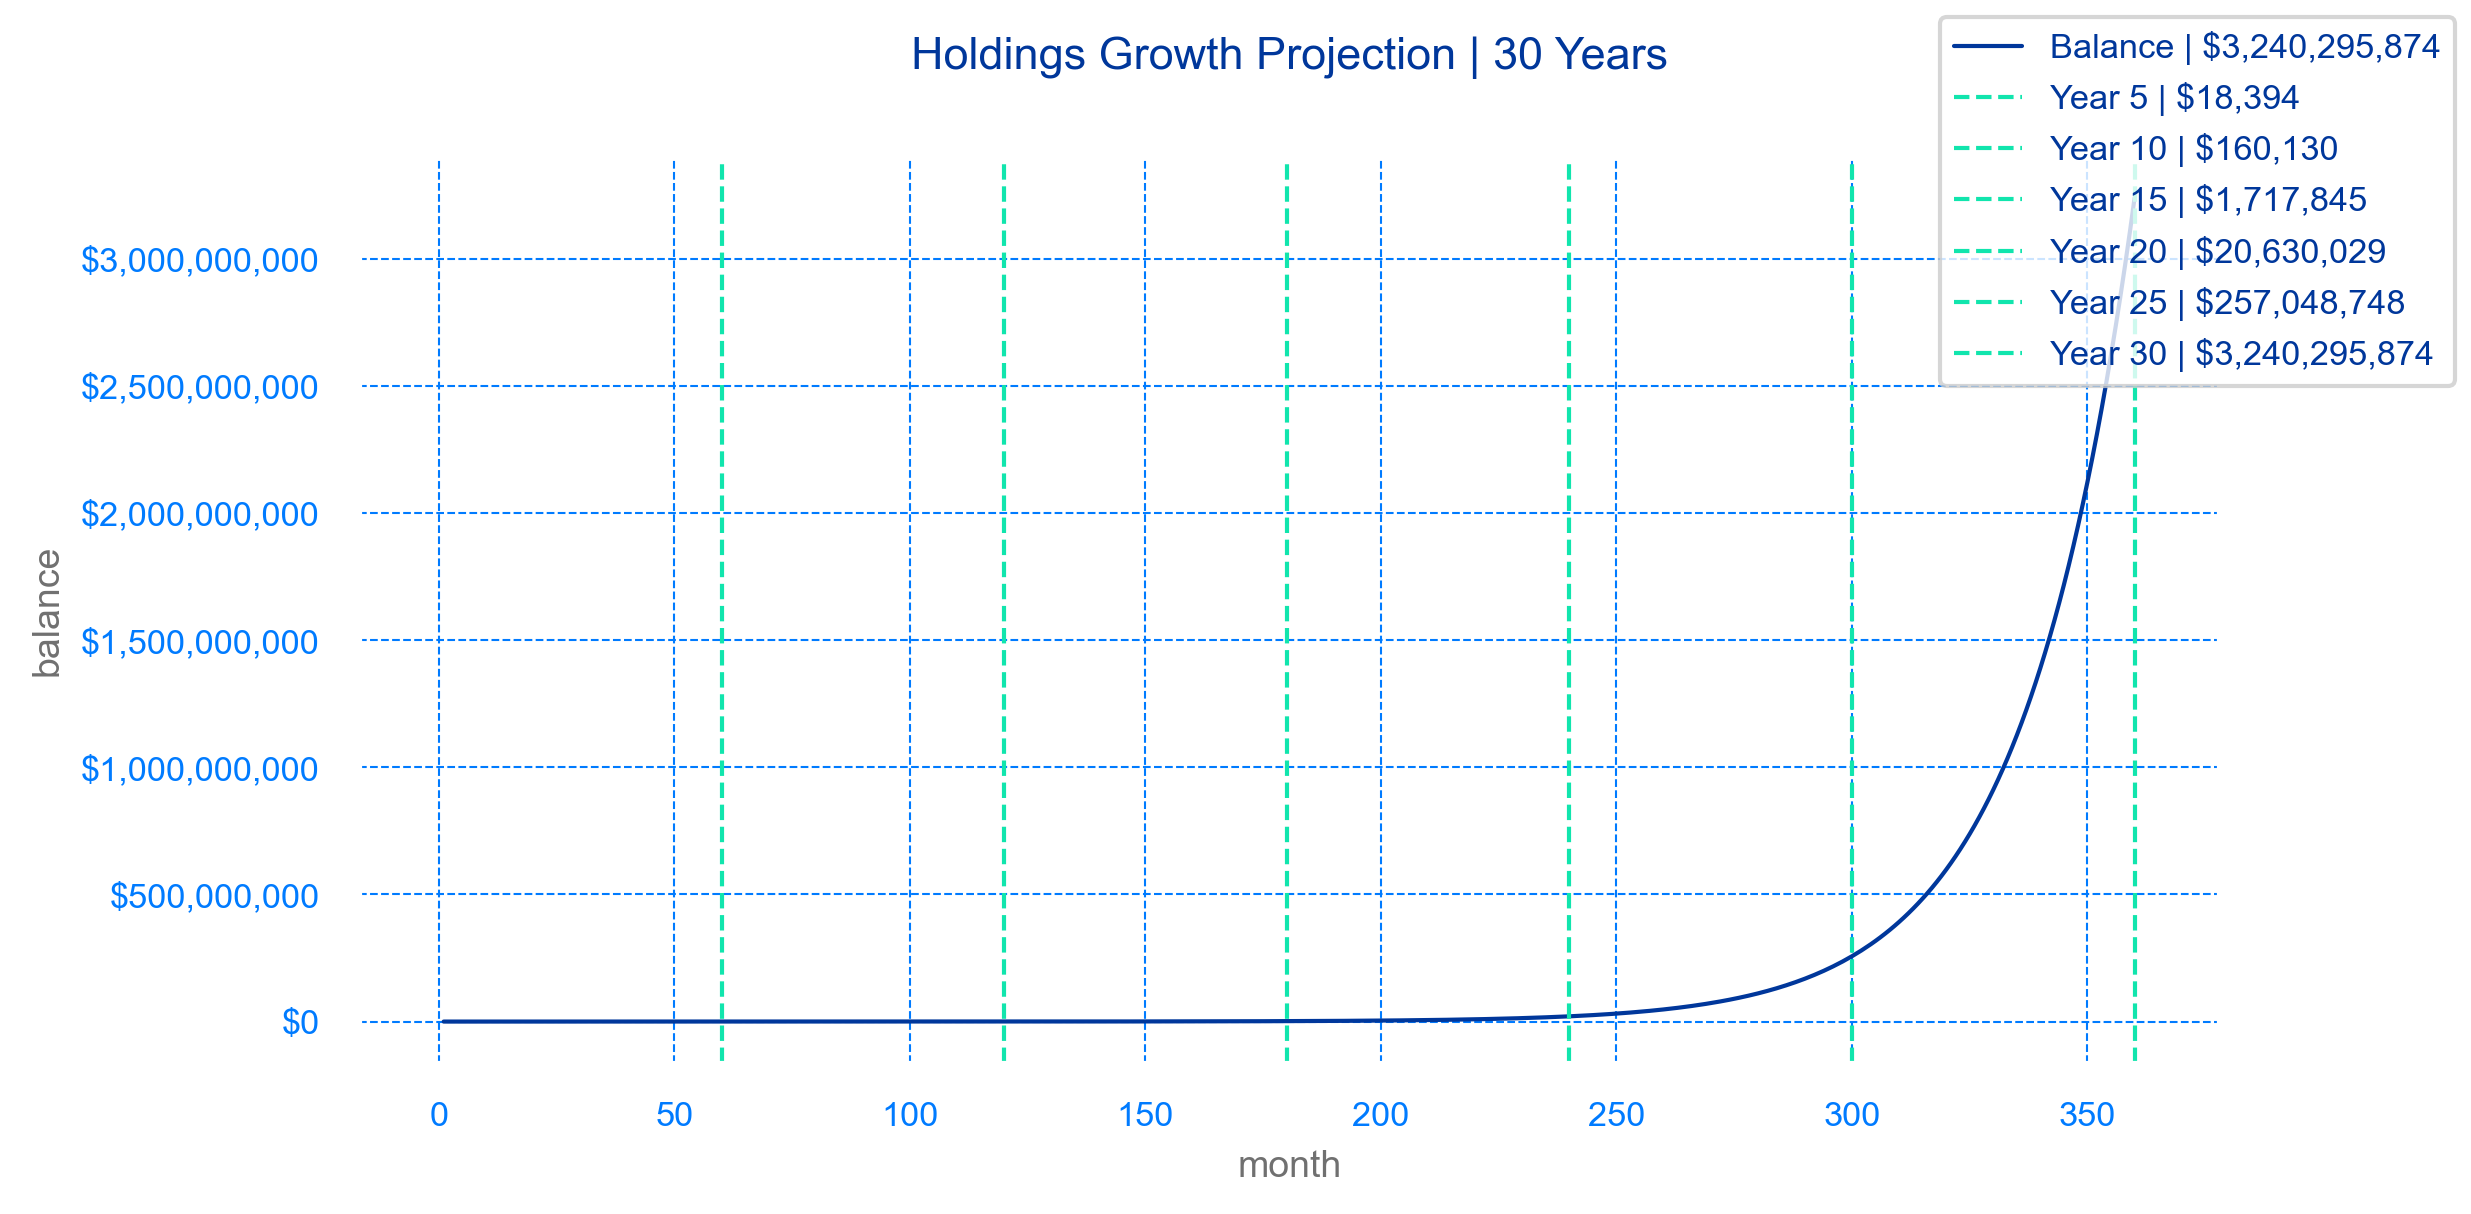

In [9]:
currency_format: str = '${x:,.0f}'
fig, ax = instance.get_figure(x='month',
                              y='balance',
                              data=holdings_growth,
                              graph_type=VisualizationType.LINE,
                              title='Holdings Growth Projection | 30 Years',
                              legend=True,
                              line_label=f'Balance | {currency_format.format(x=holdings_growth.iloc[-1]["balance"])}',
                              y_tick_format_str=currency_format)

for i, r in holdings_growth.iterrows():
    # Draw a line for every 5 year.
    if r['month'] % (12 * 5) == 0:
        year: int = int(r['month'] / 12)
        ax.axvline(x=r['month'], linestyle='--', color='#11E5AD', label=f'Year {year} | {currency_format.format(x=r["balance"])}')

fig.legends = [fig.legend()]

## Project Wealth Over Months

In [10]:
monthly_zar_deposit: float = 2000
usd_zar_exchange_rate: float = 16.17
monthly_deposits: list = [(monthly_zar_deposit / usd_zar_exchange_rate / len(holdings_with_profits)) for h in holdings_with_profits]
wealth_projection = asset_projection_engine.project_wealth_growth(holdings_with_profits=holdings_with_profits,
                                                                  monthly_deposits=monthly_deposits)

wealth_projection

,Target Balance (USD),Target Balance Eng (USD),ETA (Months),ETA (Years)
0,1.070141e+03,one thousand and seventy point one four one ze...,5,0.416667
1,1.025053e+04,"ten thousand, two hundred and fifty point five...",43,3.583333
2,1.021726e+05,"one hundred and two thousand, one hundred and ...",107,8.916667
3,1.013296e+06,"one million, thirteen thousand, two hundred an...",166,13.833333
4,1.014305e+07,"ten million, one hundred and forty-three thous...",222,18.500000
5,1.017226e+08,"one hundred and one million, seven hundred and...",277,23.083333
6,1.035152e+09,"one billion, thirty-five million, one hundred ...",332,27.666667
7,1.015024e+10,"ten billion, one hundred and fifty million, tw...",386,32.166667


In [11]:
wealth_projection['Target Balance (USD)'] = wealth_projection['Target Balance (USD)'].apply(lambda v: int(v))
wealth_projection['ETA (Years)'] = wealth_projection['ETA (Years)'].apply(lambda v: int(v))

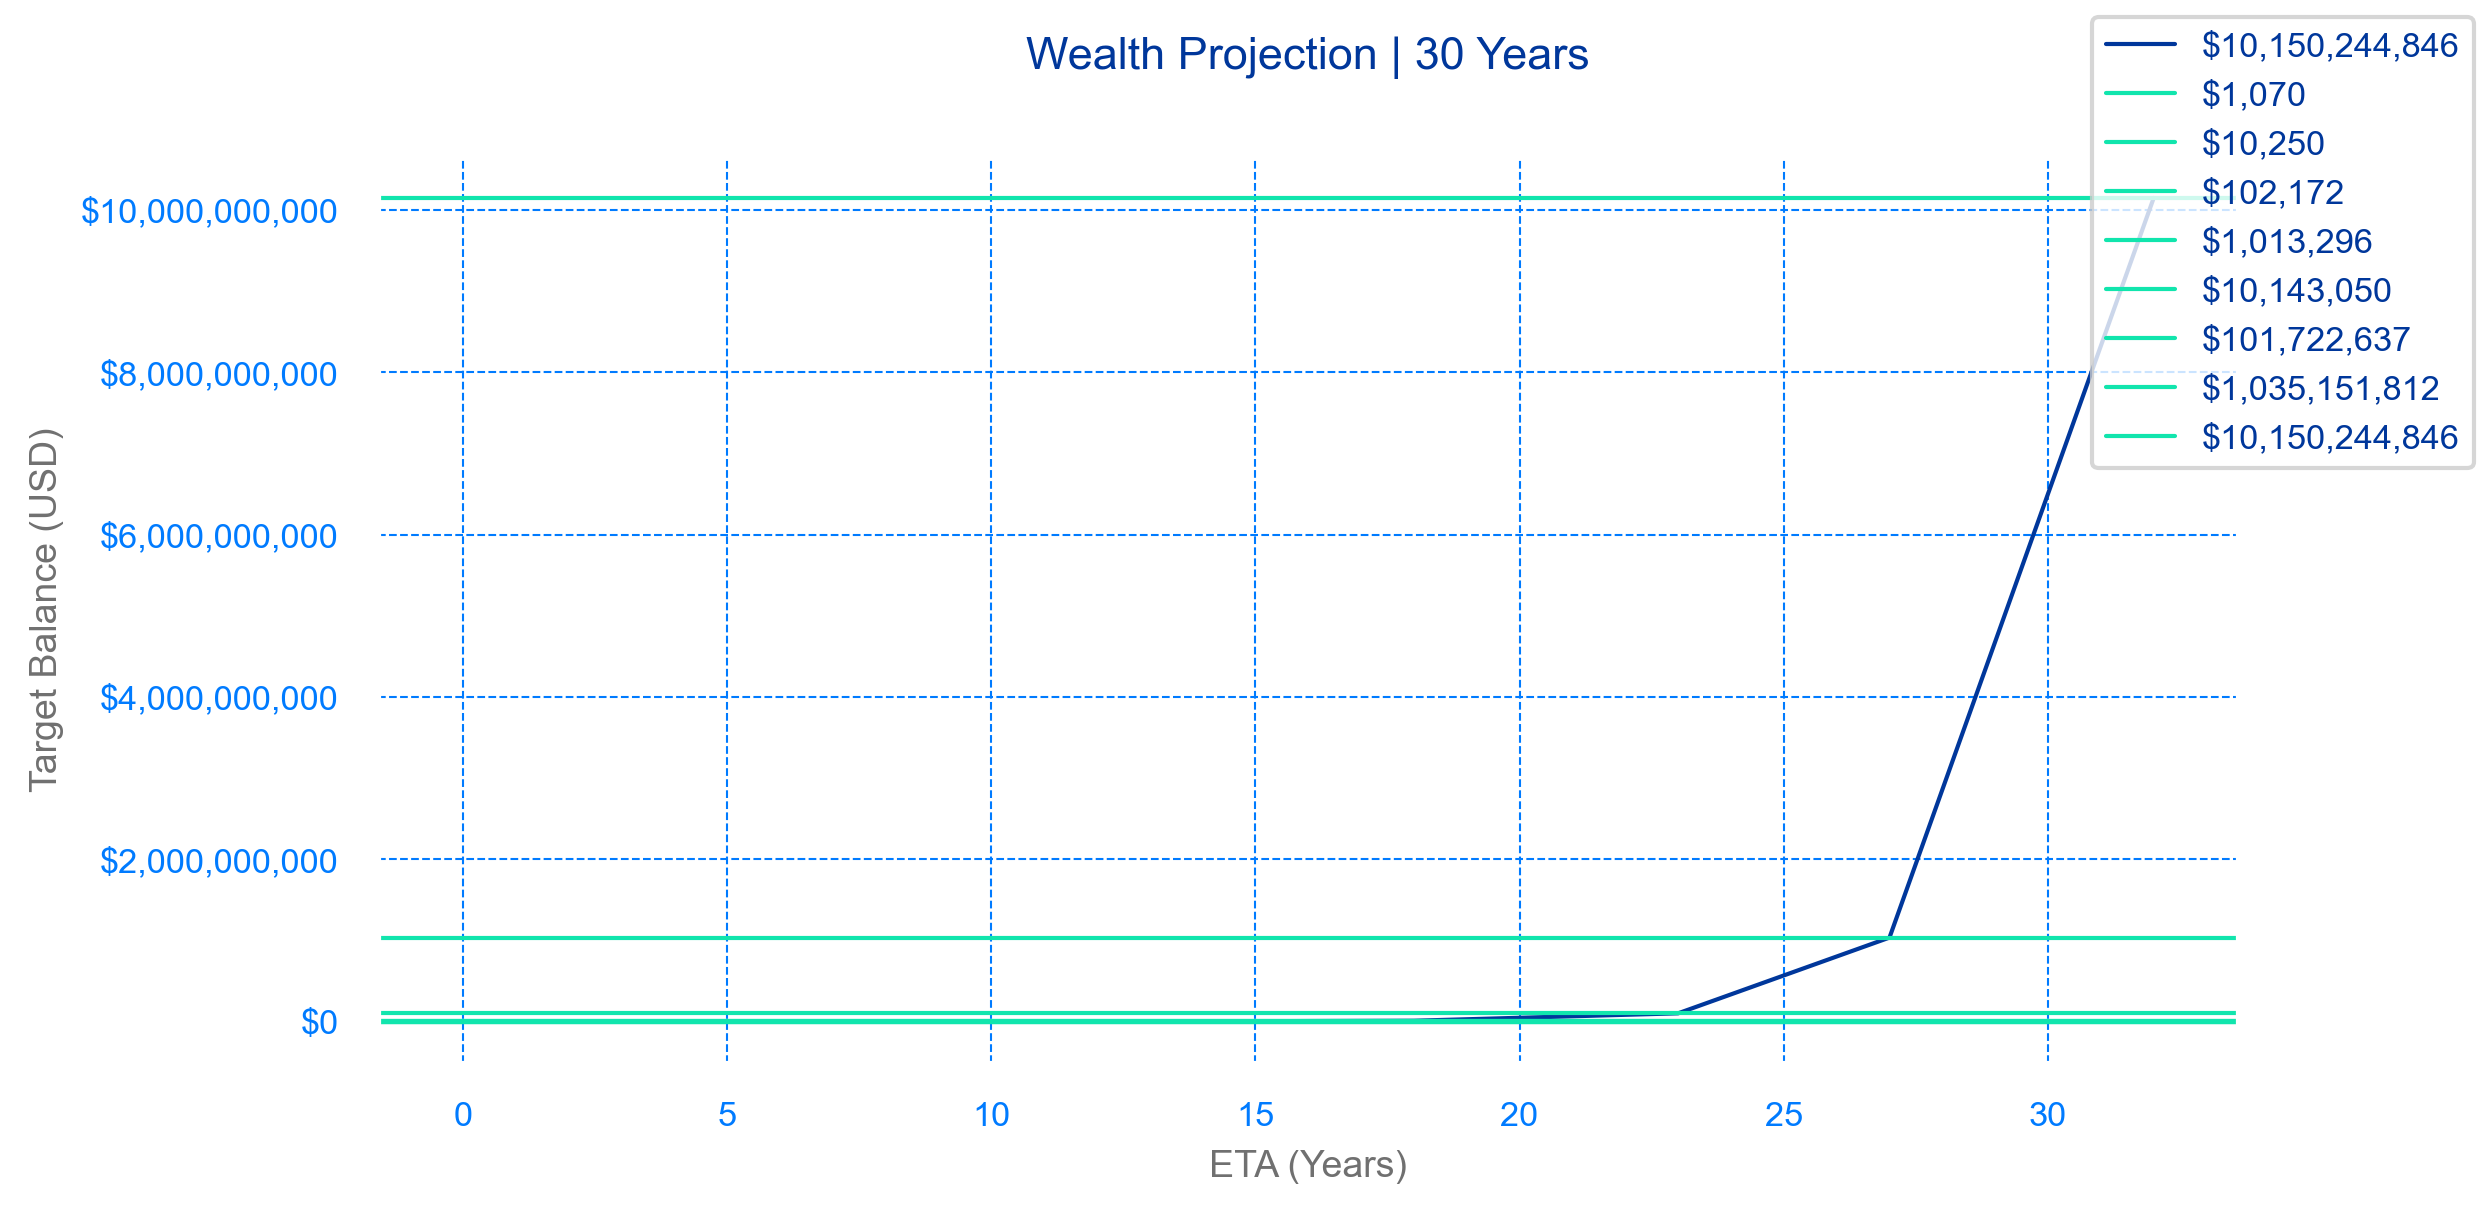

In [12]:
currency_format: str = '${x:,.0f}'
fig, ax = instance.get_figure(x='ETA (Years)',
                              y='Target Balance (USD)',
                              data=wealth_projection,
                              graph_type=VisualizationType.LINE,
                              title='Wealth Projection | 30 Years',
                              legend=True,
                              line_label=wealth_projection.iloc[-1]['Target Balance (USD)'],
                              y_tick_format_str=currency_format)

for i, r in wealth_projection.iterrows():
    ax.axhline(y=r['Target Balance (USD)'], linestyle='-', color='#11E5AD', label=currency_format.format(x=r['Target Balance (USD)']))

fig.legends = [fig.legend()]